In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import matplotlib.pyplot as plt
from NCP.model import NCPOperator, NCPModule
from NCP.nn.layers import MLP
from NCP.nn.losses import CMELoss
from NCP.metrics import hellinger, kullback_leibler, wasserstein1
from NCP.utils import frnp
import lightning as L
from NCP.nn.callbacks import LitProgressBar

import itertools

from NCP.examples.tools.plot_utils import setup_plots
from NCP.examples.tools.data_gen import gen_bimodal, get_conditional_bimodal_cdf
from NCP.examples.tools.lincde import lincde
setup_plots()

np.random.seed(0)
torch.manual_seed(0)
Ntrain = 50000
Nval = 1000         # val dataset will be used to sample the marginal distribution of Y
Ntest = 1000

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Generating bimodal data as presented in LinCDE (Gao and Hastie). X are 20 dimensional, but only the first 3 dimensions impact Y. 
- the first dimension gives the mean, 
- the second the modality (bi or uni modal) 
- the third the asymetry.

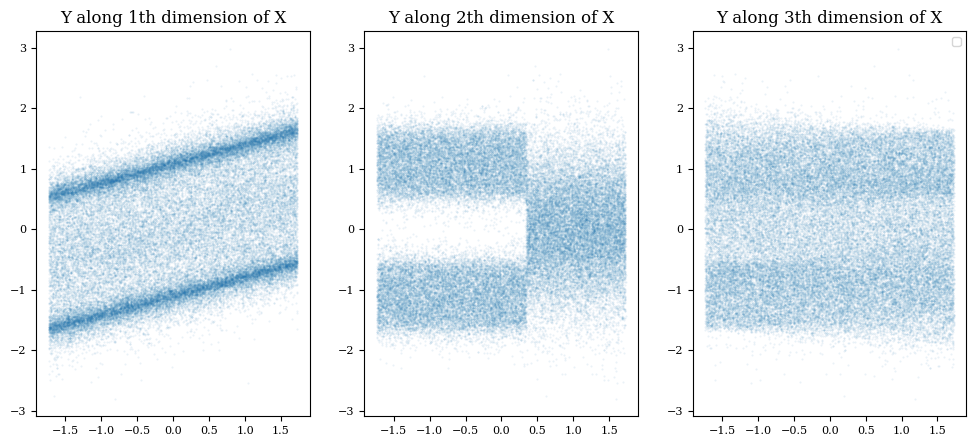

In [6]:
X_train, Y_train, X_val, Y_val, X_test, Y_test, xscaler, yscaler = gen_bimodal(0.5, 30, N_train=Ntrain, N_val=Nval, N_test=Ntest)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axes = ax.flatten()

for i, ax in enumerate(axes):
    ax.scatter(X_train[:,i], Y_train, alpha=0.1, s=0.2)
    ax.set_title(f'Y along {i+1}th dimension of X')
    if i == 0 :
        plt.legend(['train', 'val', 'test'])
plt.show()

In [11]:
lincde(X_train, Y_train)

d:\Grégoire\Documents\ncp\NCP\examples


FileNotFoundError: [Errno 2] No such file or directory: 'temp/matrix.csv'

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type        | Params
--------------------------------------
0 | model | NCPOperator | 78.2 K
--------------------------------------
78.2 K    Trainable params
0         Non-trainable params
78.2 K    Total params
0.313     Total estimated mod

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9196:   0% 0/1 [00:00<?, ?it/s, v_num=0, val_loss=-0.53, train_loss=-661]             d:\Gregoire\anaconda3\envs\koopman\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


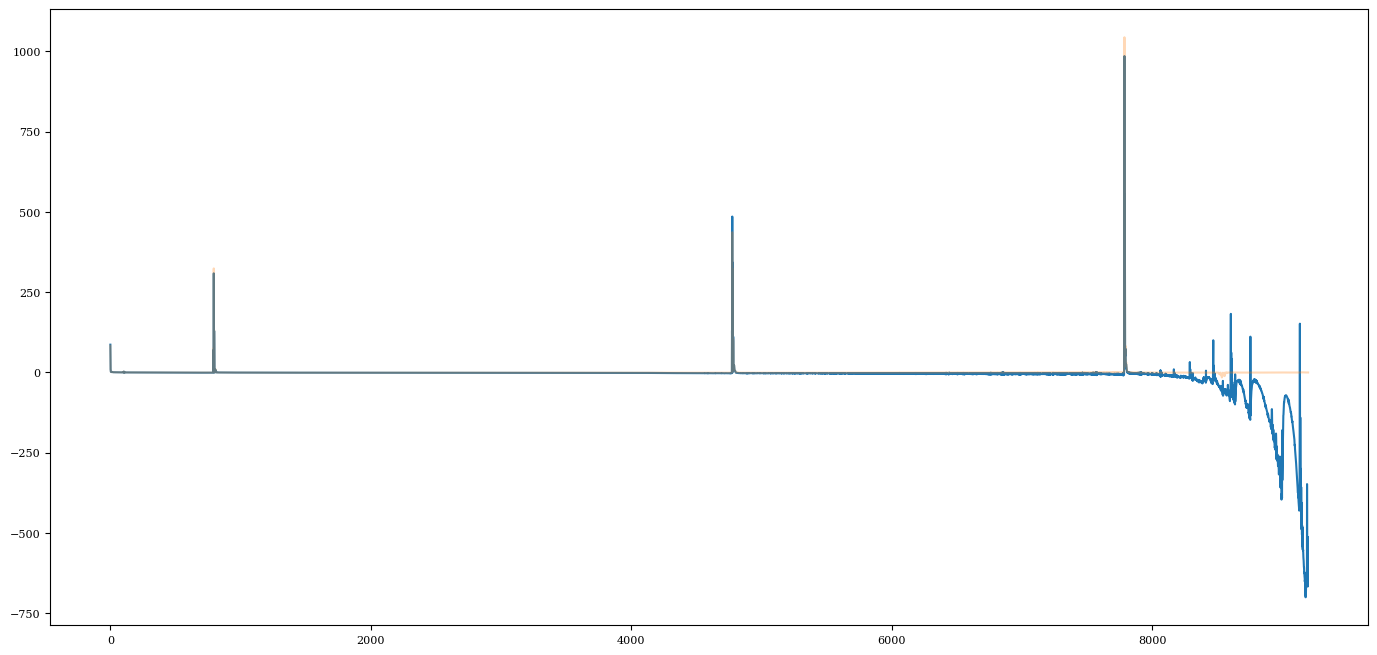

In [4]:
L.seed_everything(0)

lr = 1e-3
gamma = 1e-2
epochs = int(1e4)
output_shape = 100

MLP_kwargs_U = {
    'input_shape': X_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 3,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

MLP_kwargs_V = {
    'input_shape': Y_train.shape[-1],
    'output_shape': output_shape,
    'n_hidden': 2,
    'layer_size': 128,
    'dropout': 0,
    'iterative_whitening': False
}

optimizer = Adam
optimizer_kwargs = {
    'lr': lr
    }

loss_fn = CMELoss
loss_kwargs = {
    'mode': 'split',
    'gamma': gamma
}

reg = NCPOperator(U_operator=MLP, V_operator=MLP, U_operator_kwargs=MLP_kwargs_U, V_operator_kwargs=MLP_kwargs_V)

X_train_torch = frnp(X_train)
Y_train_torch = frnp(Y_train)
X_val_torch = frnp(X_val)
Y_val_torch = frnp(Y_val)

NCP_module = NCPModule(
    reg,
    optimizer,
    optimizer_kwargs,
    CMELoss,
    loss_kwargs
)

train_dl = DataLoader(TensorDataset(X_train_torch, Y_train_torch), batch_size=len(X_train_torch), shuffle=False, num_workers=0, pin_memory=True)
val_dl = DataLoader(TensorDataset(X_val_torch, Y_val_torch), batch_size=len(X_val_torch), shuffle=False, num_workers=0, pin_memory=True)

trainer = L.Trainer(**{
    'accelerator': device,
    'max_epochs': epochs,
    'log_every_n_steps': 1,
    'enable_progress_bar': True,
    'devices': 1,
}, callbacks=[LitProgressBar()])

trainer.fit(NCP_module, train_dataloaders=train_dl, val_dataloaders=val_dl)

plt.figure(figsize=(17, 8))
plt.plot(range(len(NCP_module.train_loss)), np.array(NCP_module.train_loss))
plt.plot(range(len(NCP_module.val_loss)), np.array(NCP_module.val_loss), alpha=0.3)
plt.show()

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

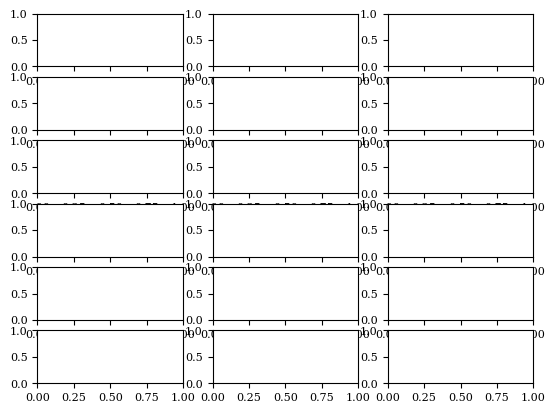

In [12]:
# todo: plot different cdfs, replicate plots from linCDE

x1 = [-0.6, 0, 0.6] # mean
x2 = [-0.6, 0, 0.6] # modality
x3 = [-0.6, 0, 0.6] # asymetry

xs = itertools.product(x1, x2, x3)

fig, ax = plt.subplots(nrows=(len(x1)+len(x3)), ncols=len(x2))
axes = ax.flatten()

for i, xi in enumerate(xs):
    x = list(xi) + [0]*17          # fill all other dimensions by 0
    x_scaled = torch.Tensor(xscaler.transform([x])).to(device=device)
    fys, cdf_pred = reg.cdf(x_scaled, Y_val, postprocess='whitening')
    fys = yscaler.inverse_transform(fys.reshape([-1, 1])).flatten()

    true_cdf = get_conditional_bimodal_cdf(x, fys)

    axes[i].plot(fys, cdf_pred)
    axes[i].plot(fys, true_cdf)
    axes[i].set_title(f'x={round(x, 3)}')
    print('result for x=', round(x, 3))
    print(f'- KL: {kullback_leibler(cdf_pred, true_cdf, fys)}')
    print(f'- Hellinger: {hellinger(cdf_pred, true_cdf, fys)}')

plt.show()

Should we verify that the other dimensions are independent?